In [8]:
import random
import torch
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = int(capacity) # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled
        self.device = device
    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(np.array(x)).to(self.device), list(zip(*batch))))
    def __len__(self):
        return len(self.data)

In [9]:
import torch

def greedy_action(network, state):
    device = "cuda" if next(network.parameters()).is_cuda else "cpu"
    with torch.no_grad():
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).item()

In [13]:
import numpy as np
import torch
import torch.nn as nn

class dqn_agent:
    def __init__(self, config, model):
        device = "cuda" if next(model.parameters()).is_cuda else "cpu"
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'], device)
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.model = model 
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.model(Y).max(1)[0].detach()
            #update = torch.addcmul(R, self.gamma, 1-D, QYmax)
            update = torch.addcmul(R, 1-D, QYmax, value=self.gamma)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0

        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)

            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = greedy_action(self.model, state)

            # step
            next_state, reward, done, trunc, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # train
            self.gradient_step()

            # next transition
            step += 1
            if done or trunc:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", batch size ", '{:5d}'.format(len(self.memory)), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      sep='')
                state, _ = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return

In [16]:
from gymnasium.wrappers import TimeLimit
from env_hiv import HIVPatient

env = TimeLimit(
    env=HIVPatient(domain_randomization=False), max_episode_steps=200
)  # The time wrapper limits the number of steps in an episode at 200.
# Now is the floor is yours to implement the agent and train it.

cuda
Episode   1, epsilon   0.82, batch size   200, episode return 8249269.1
Episode   2, epsilon   0.62, batch size   400, episode return 13347030.5
Episode   3, epsilon   0.43, batch size   600, episode return 8599686.9
Episode   4, epsilon   0.23, batch size   800, episode return 12092679.7
Episode   5, epsilon   0.03, batch size  1000, episode return 11901825.6
Episode   6, epsilon   0.01, batch size  1000, episode return 3658478.3
Episode   7, epsilon   0.01, batch size  1000, episode return 3089046.0
Episode   8, epsilon   0.01, batch size  1000, episode return 3444378.4
Episode   9, epsilon   0.01, batch size  1000, episode return 3437368.1
Episode  10, epsilon   0.01, batch size  1000, episode return 5890055.5
Episode  11, epsilon   0.01, batch size  1000, episode return 5366609.1
Episode  12, epsilon   0.01, batch size  1000, episode return 7153756.1
Episode  13, epsilon   0.01, batch size  1000, episode return 4406158.1
Episode  14, epsilon   0.01, batch size  1000, episode r

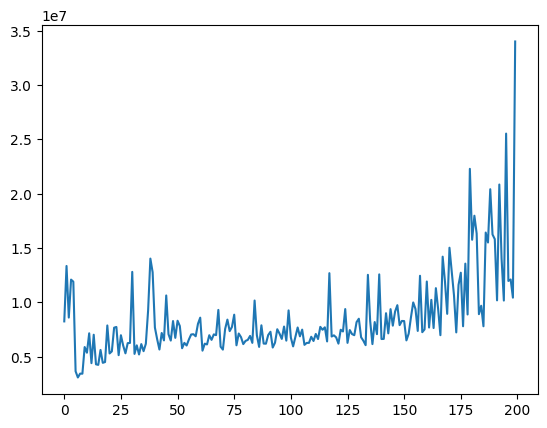

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Declare network
state_dim = env.observation_space.shape[0]
n_action = env.action_space.n 
nb_neurons=24
DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

# DQN config
config = {'nb_actions': env.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.99,
          'buffer_size': 1000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 20}

# Train agent
agent = dqn_agent(config, DQN)
scores = agent.train(env, 200)
plt.plot(scores)

In [20]:
import os
torch.save(DQN, os.path.join(os.getcwd(), "models/DQN1.pkl"))